<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Intel_Image_Classification10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install the FASTAI and related dependencies

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

In [0]:
import torch
print(torch.__version__)

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

#  Intel Scene Classification Image Dataset

## Looking at the data

###Getting Dataset from Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"navneetkrch","key":"4910f3543e9486158ccfa00ca84b274f"}'> ~/.kaggle/kaggle.json  # Replace
!chmod 600 kaggle.json


In [0]:
!mkdir -p data
!mkdir -p data/test
!kaggle datasets download -d nitishabharathi/scene-classification

In [9]:
!unzip scene-classification.zip 

Archive:  scene-classification.zip
  inflating: test_WyRytb0.csv        
  inflating: train-scene classification.zip  


In [0]:
!unzip train-scene\ classification.zip -d data/
!mv test_WyRytb0.csv data/test.csv
!mv data/train.csv data/train/labels.csv

In [11]:
print("all files unzipped. Images in train folder and labels in test.csv")

all files unzipped. Images in train folder and labels in test.csv


### Separate the Test Files in a separate Test Folder

In [25]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

image_name
0      3.jpg
1      5.jpg
2      6.jpg
3     11.jpg
4     14.jpg

In [0]:
test_df.to_csv("out.csv", index=False,header=False) ## create the csv file without the Headers
#Just the header has been removed from the test labels for the below cell to run correctly

#test_df2 = pd.read_csv('out.csv')
#test_df2.head() # to check the csv file without Header
!rsync --files-from=out.csv data/train data/test


In [18]:
print("Now we have separated the Test files from Train and put in Test Folder itself")

Now we have separated the Test files from Train and put in Test Folder itself


###Setting the path for data

We are going to use the [Intel Image Scene](https://www.kaggle.com/nitishabharathi/scene-classification) by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/) which features 6 scenes.

Our model will need to learn to differentiate between these 6 distinct categories. 
We use **FASTAI-V1** model to get the results.

####DATASET DESCRIPTION
**There are 17034 images in train and 7301 images in test data.**

The categories of natural scenes and their corresponding labels in the dataset are as follows -

 ** 'buildings' -> 0,**

**'forest' -> 1,** 

**'glacier' -> 2,**

**'mountain' -> 3,**

**'sea' -> 4, **

**'street' -> 5 **

There are three files provided to you, viz **train.zip, test.csv and sample_submission.csv** which have the following structure.

Variable	Definition

image_name	Name of the image in the dataset (ID column)

label	Category of natural scene (target column)

**train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv**

In [26]:
path = 'data';path

'data'

In [0]:
path_img = 'data/train'

In [28]:
fnames = get_image_files(path_img)
fnames[:5]


[PosixPath('data/train/17693.jpg'),
 PosixPath('data/train/15942.jpg'),
 PosixPath('data/train/19621.jpg'),
 PosixPath('data/train/20119.jpg'),
 PosixPath('data/train/21370.jpg')]

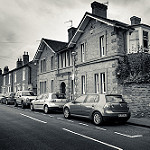

In [29]:
from IPython.display import Image 
Image(filename='data/train/13664.jpg')

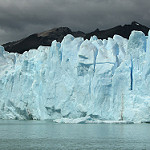

In [30]:
from IPython.display import Image 
Image(filename='data/train/11432.jpg')

In [31]:
os.listdir('data/')

['train', 'test.csv', 'test']

###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **6 labels** are stored based on the csv files.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from CSV / DataFrame](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_csv).

##Loading Labels [From_CSV](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L131)

from_csv[source]

from_csv(`path`:PathOrStr, `folder`:PathOrStr=`'.'`, `sep`=`None`, `csv_labels`:PathOrStr=`'labels.csv'`, `valid_pct`:float=`0.2`, `fn_col`:int=`0`, `label_col`:int=`1`, `suffix`:str=`''`, `header`:Union[int, str, NoneType]=`'infer'`, `kwargs`:Any) → ImageDataBunch

Create from a csv file in path/csv_labels.

**data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=24);**




**File Structure**

path\

    labels.csv -> label for training images
    test.csv -> list of test images without labels
    
    train\
      training images
    test\
       testing images
      
 train.csv contains correct labels of **17034 images** in train 
 
 test.csv contains list of **7301 images** in train folder itself but without labels.


In [0]:
tfms = get_transforms()
data = ImageDataBunch.from_csv(path_img,train= ' ', '../labels.csv', valid_pct=0.2, ds_tfms=tfms, size=224,classes=[str(i) for i in range(6)])

In [0]:
tfms = get_transforms()
data = ImageDataBunch.from_csv(path_img, ds_tfms=tfms, size=224)

In [0]:
label_df = pd.read_csv('data/train/labels.csv')
label_df.head()

image_name  label
0      0.jpg      0
1      1.jpg      4
2      2.jpg      5
3      4.jpg      0
4      7.jpg      4

In [0]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4, 5]


(6, 6)

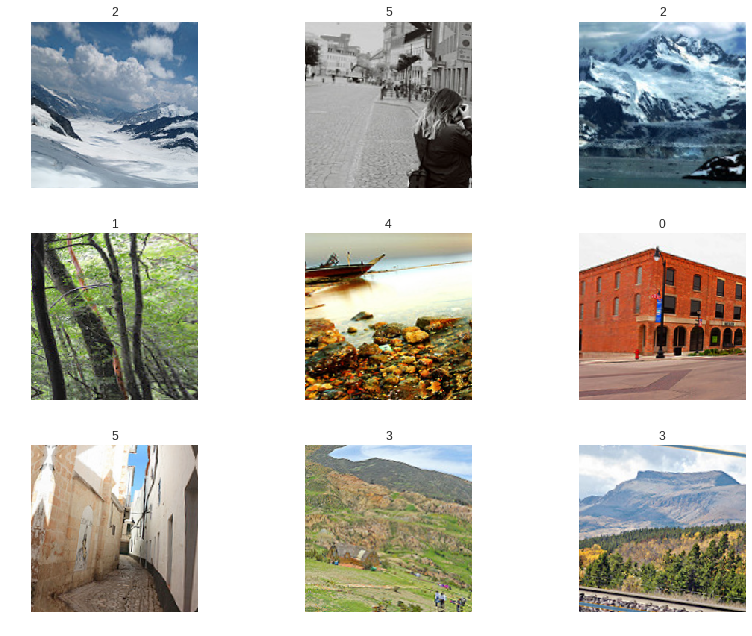

In [0]:
data.show_batch(rows=3, figsize=(12,9))

# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
#For Metrics to have Top 3 results
from fastai import *
from sklearn import metrics as skm

In [0]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


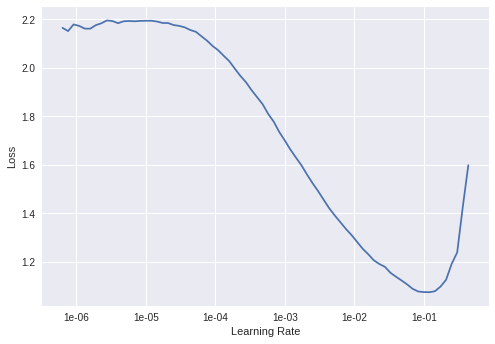

In [0]:
learn.lr_find()
learn.recorder.plot()

##Train and save the model checkpoint

In [0]:
learn.fit_one_cycle(10) ## best way to fit as of 2018
print("learning complete")

learning complete


In [0]:
print("we save after 1st weights are learned")
learn.save('stage-1-50')
learn.load('stage-1-50')

Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()

#learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-2))
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

In [0]:
learn.save('stage-3-50')
#learn.load('stage-2-50')

print("we save after 2nd weights are learned")

we save after 2nd weights are learned


If it doesn't, you can always go back to your previous model.

In [0]:
print("weights loaded")

weights loaded


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

**interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability**

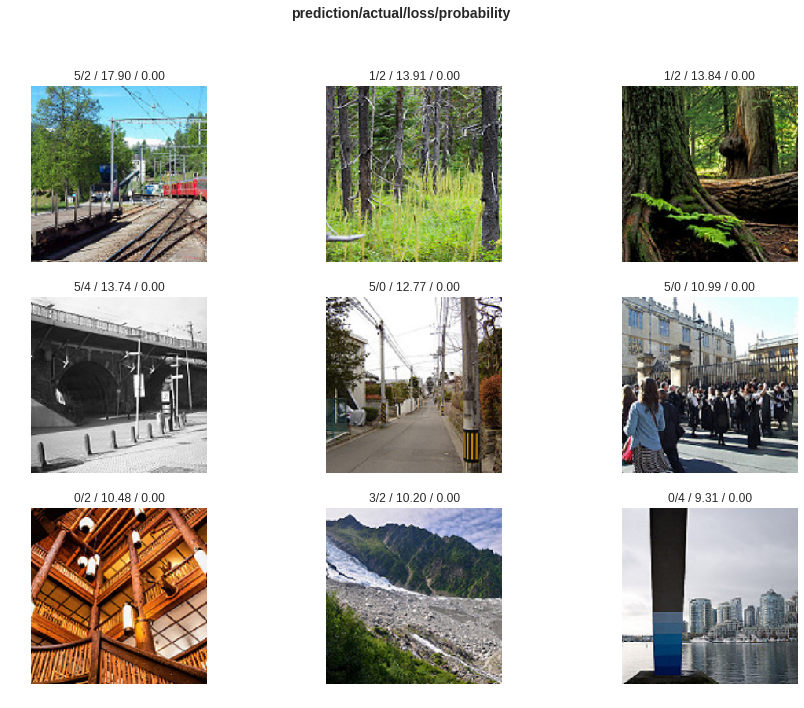

In [0]:
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [0]:
interp.most_confused()

[(2, 3, 63),
 (0, 5, 38),
 (3, 2, 30),
 (5, 0, 12),
 (2, 4, 11),
 (2, 1, 9),
 (4, 2, 7),
 (3, 4, 5),
 (4, 3, 4),
 (1, 3, 2),
 (3, 1, 2),
 (4, 5, 2)]

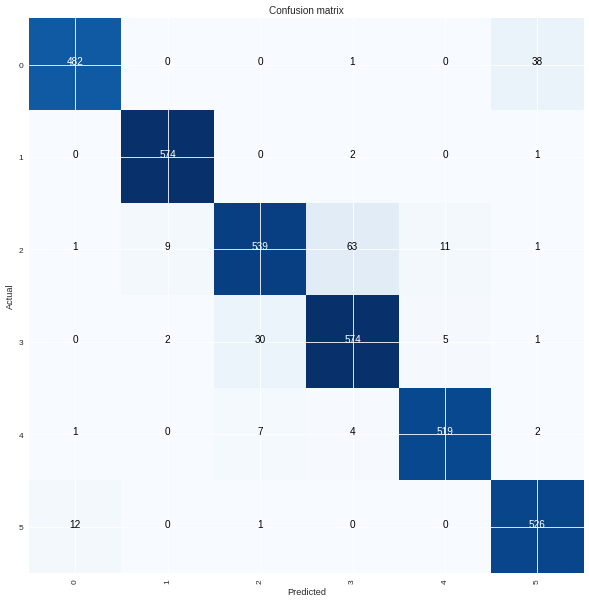

In [0]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)



---



## Use the trained model to predict on the Test Dataset

###Get the documentation from the 

https://docs.fast.ai/data_block.html#Add-a-test-set

To add a test set, you can use one of the two following methods.

**add_test** 
[source_code](https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L486
)

add_test(`items`:Iterator[T_co], `label`:Any=`None`)

Note: Here `items` can be an `ItemList` or a collection.




**add_test_folder** 
[source_code](https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L496
)

add_test_folder(`test_folder`:str=`'test'`, `label`:Any=`None`)

Add test set containing items from test_folder and an arbitrary label.

Important! No labels will be collected if available. Instead, either the passed label argument or a first label from train_ds will be used for all entries of this dataset.

**In the fastai framework test datasets have no labels - this is the unknown data to be predicted.**





If you want to use a test dataset with labels, you probably need to use it as a validation set, as in:

**data_test** = (ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        ...)
        
Another approach, where you do use a normal validation set, and then when the training is over, you just want to validate the test set w/ labels as a validation set, you can do the below


In [0]:
#treated as string to make it as multiple lines of code
""" 
tfms = []
path = Path('data').resolve()
data = (ImageItemList.from_folder(path)
        .split_by_pct()
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize() ) 
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5,1e-2)

# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.data = data_test
learn.validate()
""" # end of comment of multiple lines of code

In [0]:
#adding/changing the datablock to contain the test files as well

In [0]:
data_test = (ImageItemList.from_csv(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.data = data_test
learn.validate()
